In [62]:
import datetime
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Model Training
Training is done using Tensorflow 2.0 and Keras framework. To save time, we will do transfer learning instead of training from scratch. The pretrained model will act as a feature extractor. InceptionV3 model that is previously trained on ImageNet is chosen because it has low number of parameters (24M) while having a high accuracy (78%) on the ImageNet dataset. 

## Model Definition
We use the InceptionV3 base model and add our own classifier dense layer to it to predict our 2 image class.

In [68]:
batch_size=32
epochs=10

In [6]:
image_dir = '../data/clahe_applied/'

In [8]:
n_class = len(os.listdir(image_dir))

In [12]:
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# add dropout as it will probably overfit with low number of class
x = Dropout(0.5)(x)
# add dense layer to predict binary class 0 or 1
predictions = Dense(1, activation='sigmoid')(x)

87916544/87910968 [==============================] - 4s 0us/step


In [14]:
model = Model(inputs=base_model.input, outputs=predictions)

In [18]:
# freeze the base model
for layer in base_model.layers:
    layer.trainable = False

In [19]:
# compile the model 
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

In [20]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

# Preparing Datasets
Load the images into memory (Use a generator if not enough memory)

In [24]:
# by default, input image size for InceptionV3 is 299 x 299
target_size = (299, 299)

X, y = [], []
classes = {}
for i, _class in enumerate(os.listdir(image_dir)):
    classes[i] = _class
    for img_path in os.listdir(os.path.join(image_dir, _class)):
        X.append(img_to_array(load_img(os.path.join(image_dir, _class, img_path), target_size=target_size)))
        y.append(i)
X = np.array(X)
y = np.array(y)

In [28]:
X.shape, y.shape

((2682, 299, 299, 3), (2682,))

In [29]:
train_x, valid_x, train_y, valid_y = train_test_split(X, y)

In [56]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   rotation_range=15,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   brightness_range=(0.9, 1.1),
                                   fill_mode='constant')

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,)

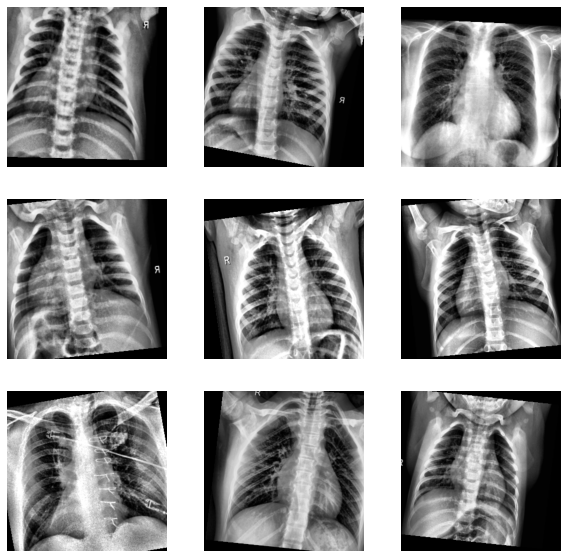

In [55]:
# view a few augmentation
# prepare iterator
it = train_datagen.flow(train_x, batch_size=1)
plt.figure(figsize=(10, 10))
# generate samples and plot
for i in range(9):
    plt.subplot(3, 3, i+1)
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    plt.imshow(image)
    plt.axis('off')
# show the figure
plt.show()

In [57]:
train_gen = train_datagen.flow(train_x, train_y, batch_size=batch_size)
valid_gen = train_datagen.flow(valid_x, valid_y, batch_size=batch_size, shuffle=False)

In [60]:
output_folder = '../outputs'
os.makedirs(output_folder, exist_ok=True)
logdir = os.path.join(output_folder, "tensorboard_logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [63]:
callbacks = [EarlyStopping(min_delta=0.001, patience=5),
             ReduceLROnPlateau(patience=2, verbose=1),
             ModelCheckpoint(os.path.join(output_folder, 'model_checkpoint.h5'), save_best_only=True),
             TensorBoard(logdir)
            ]

In [66]:
%load_ext tensorboard
%tensorboard --logdir logdir

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 15544), started 0:02:45 ago. (Use '!kill 15544' to kill it.)

In [ ]:
model.fit(train_gen, validation_data=valid_gen, epochs=epochs, verbose=2, callbacks=callbacks)